# TensorFlow Datasets 

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

Typically, to train neural networks, we need to stream large datasets (data that is too large to fit in computer memory). In this case, we can't use `fit` on Keras models and we have to load the data from storage in chunks as we shall see later. TensorFlow provides the `tf.data.Dataset` API to facilitate efficient input pipelines. As we will see below, `Dataset` usage follows a common pattern:

1. Create a source dataset from your input data.
2. Apply dataset transformations to preprocess the data.
3. Iterate over the dataset and process the elements.

```{margin}
⚠️ **Attribution:** This notebook is builds on the [Chapter 13 notebook](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch13/ch13_part1.ipynb) of {cite}`RaschkaMirjalili2019` which is [released under MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt).
```



In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset from tensors

We can initialize a TF dataset from an existing tensor as follows:

In [5]:
a = tf.range(10)
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

<TensorSliceDataset shapes: (), types: tf.int32>


2022-03-12 03:12:30.084613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-12 03:12:30.085759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
for item in ds:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [7]:
ds_batch = ds.batch(4, drop_remainder=False) # Analogous to drop_last in PyTorch
for batch in ds_batch:
    print(batch)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


To create joint datasets, simply pass a tuple of tensors in `from_tensor_slices`:

In [8]:
import pandas as pd

X = tf.random.uniform([10, 3], dtype=tf.float32)
y = tf.range(10)

ds_joint = tf.data.Dataset.from_tensor_slices((X, y))
for x, t in ds_joint.batch(4):
    print(pd.DataFrame({
        'X1': x.numpy()[:, 0],
        'X2': x.numpy()[:, 1], 
        'X3': x.numpy()[:, 2], 
        'y': t.numpy()
    }), '\n')

         X1        X2        X3  y
0  0.866782  0.891457  0.922690  0
1  0.141824  0.631502  0.620417  1
2  0.316360  0.740578  0.941866  2
3  0.349700  0.380648  0.419085  3 

         X1        X2        X3  y
0  0.114882  0.234817  0.909981  4
1  0.635315  0.265292  0.537534  5
2  0.000992  0.017253  0.806648  6
3  0.643010  0.948952  0.662544  7 

         X1        X2        X3  y
0  0.534027  0.147345  0.335028  8
1  0.811870  0.875989  0.797427  9 



## Transformations

Applying transformations to each individual element of a TF dataset is easy &mdash; just call `map`. This will return a dataset where each streamed instance is a transformed version of the original instance.

In [9]:
X_max = tf.reduce_max(X, axis=0)
X_min = tf.reduce_min(X, axis=0)
ds_transformed = ds_joint.map(lambda x, y: (tf.math.divide(x - X_min, X_max - X_min), y))
for x, t in ds_transformed.batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  1.000000  0.938289  0.968400  0
1  0.162663  0.659278  0.470289  1
2  0.364254  0.776350  1.000000  2
3  0.402762  0.390035  0.138517  3 

         X1        X2        X3  y
0  0.131544  0.233513  0.947457  4
1  0.732652  0.266222  0.333707  5
2  0.000000  0.000000  0.777175  6
3  0.741540  1.000000  0.539710  7 

         X1        X2        X3  y
0  0.615663  0.139628  0.000000  8
1  0.936575  0.921688  0.761981  9 



2022-03-12 03:13:31.328772: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Applying this sort of transformation can be used for a user-defined function. 
For example, if we have a dataset created from the list of image filenames on disk, 
we can define a function to load the images from these filenames and apply that 
function by calling the `.map()` method. 

## Shuffle + Batch + Repeat = Epochs

To train a neural network using SGD, 
it is important to feed training data as randomly shuffled batches. (Otherwise, it biases the weight updates with the ordering of the input data.) TF provides a `.shuffle` method on dataset objects with a `buffer_size` parameter. This [answer](https://stackoverflow.com/a/47025850) in SO provides a good explanation for `buffer_size`:

> [`Dataset.shuffle()` is designed] to handle datasets that are too large to fit in memory. Instead of shuffling the entire dataset, it maintains a buffer of `buffer_size` elements, and randomly selects the next element from that buffer (replacing it with the next input element, if one is available). <br><br>
Changing the value of `buffer_size` affects how uniform the shuffling is: if `buffer_size` is greater than the number of elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all. For very large datasets, a typical "good enough" approach is to randomly shard the data into multiple files once before training, then shuffle the filenames uniformly, and then use a smaller shuffle buffer. However, the appropriate choice will depend on the exact nature of your training job.

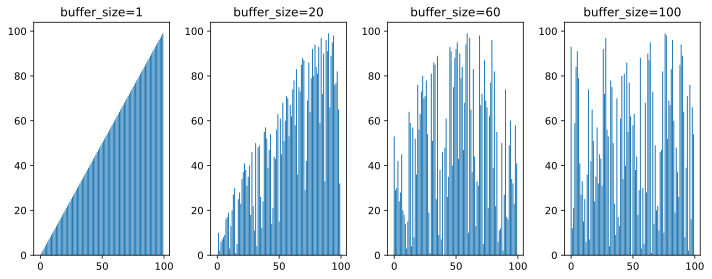

In [44]:
import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

fig = plt.figure(figsize=(10, 4))
buffer_size = [1, 20, 60, 100]
for i in range(len(buffer_size)):
    shuffled_data = []
    ds_range = tf.data.Dataset.from_tensor_slices(tf.range(100))
    for x in ds_range.shuffle(buffer_size[i]).batch(1):
        shuffled_data.append(x.numpy()[0])

    ax = fig.add_subplot(1, 4, i+1)
    ax.bar(range(100), shuffled_data)
    ax.set_title(f"buffer_size={buffer_size[i]}")

plt.tight_layout()
plt.show()

Furthermore, `shuffle` has an important argument `reshuffle_each_iteration` that controls whether the shuffle order should be different each time the dataset is iterated over. This is set to `True` by default. 

In [29]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3)
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[2, 1, 0, 1, 0, 2]

In [30]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.shuffle(3, reshuffle_each_iteration=False)
dataset = dataset.repeat(2)
list(dataset.as_numpy_iterator())

[2, 1, 0, 2, 1, 0]

When training a model for multiple epochs, we need to shuffle and iterate over the dataset by the desired number of epochs. To repeat the dataset, we use the `.repeat` method on the dataset object. The following pattern is the correct order of creating epochs. For training, it is recommended to set `drop_remainder=True` in `.batch()` to drop the last mini batch of size 1. 

In [31]:
buffer_size = 6
for x, t in ds_transformed.shuffle(buffer_size).batch(3).repeat(2):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.000000  0.000000  0.117776  1
1  0.990974  0.524492  0.544873  4
2  0.682461  0.672238  0.000000  2 

         X1        X2        X3  y
0  1.000000  0.861626  1.000000  0
1  0.185321  0.382253  0.442996  6
2  0.704992  0.918073  0.359918  9 

         X1        X2        X3  y
0  0.052846  0.511760  0.510437  8
1  0.487543  0.523834  0.108017  3
2  0.830556  1.000000  0.384701  7 

         X1        X2        X3  y
0  0.321789  0.967327  0.768954  5 

         X1        X2        X3  y
0  0.000000  0.000000  0.117776  1
1  0.185321  0.382253  0.442996  6
2  0.682461  0.672238  0.000000  2 

         X1        X2        X3  y
0  0.052846  0.511760  0.510437  8
1  0.321789  0.967327  0.768954  5
2  0.704992  0.918073  0.359918  9 

         X1        X2        X3  y
0  1.000000  0.861626  1.000000  0
1  0.990974  0.524492  0.544873  4
2  0.830556  1.000000  0.384701  7 

         X1        X2        X3  y
0  0.487543  0.523834  0.108017  3 



To see this more transparently, consider the simple dataset:

In [32]:
dataset = tf.data.Dataset.range(10).shuffle(6).batch(3).repeat(2)
list(dataset.as_numpy_iterator())

[array([4, 6, 0]),
 array([1, 3, 9]),
 array([5, 8, 2]),
 array([7]),
 array([2, 0, 3]),
 array([6, 7, 9]),
 array([1, 5, 4]),
 array([8])]

## Dataset from local files

We can get filenames using `.glob` on a `pathlib.Path` object as follows:

In [33]:
import pathlib
import os

cat_imgdir_path = pathlib.Path("../../../input/cat2dog/cat2dog/trainA")
dog_imgdir_path = pathlib.Path("../../../input/cat2dog/cat2dog/trainB")

cat_file_list = sorted([str(path) for path in cat_imgdir_path.glob("*.jpg")])
dog_file_list = sorted([str(path) for path in dog_imgdir_path.glob("*.jpg")])

Visualizing image sets for cats and dogs:

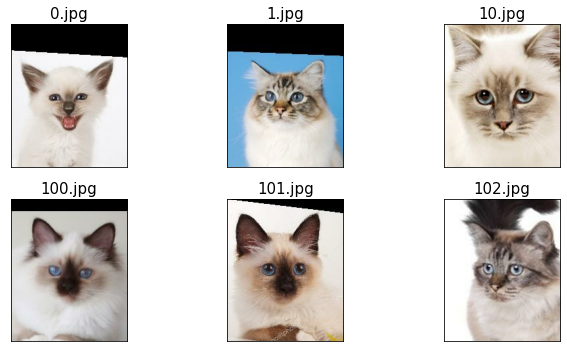

In [34]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(cat_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

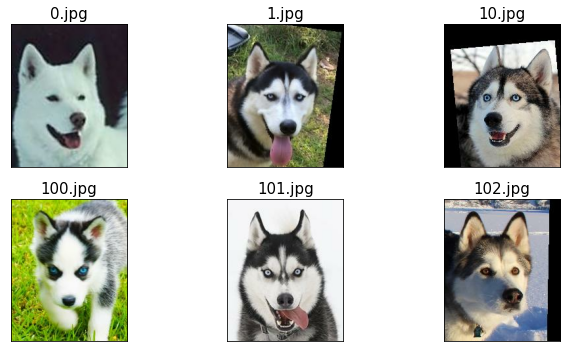

In [35]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(dog_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

Instead of having a dataset of arrays for images, and their corresponding labels, we can create a dataset of filenames and their labels. Then, we can transform the filenames to images using a mapping to load and preprocess images given their filenames.

0


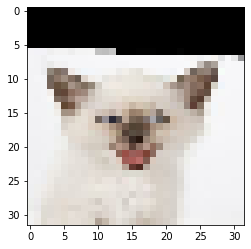

In [36]:
from functools import partial

# Define mapping function: (filename, label) -> (RGB array, label)
def load_and_preprocess(path, label, img_width=124, img_height=124):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img /= 255.0
    return img, label

# Create dataset of RGB arrays resized to 32x32x3
filenames = cat_file_list + dog_file_list
labels = [0] * len(cat_file_list) + [1] * len(dog_file_list)
filenames_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
images_dataset = filenames_dataset.map(partial(load_and_preprocess, img_width=32, img_height=32))

# Display one image and its label (0 = cat, 1 = dog) 
img, label = next(iter(images_dataset.batch(1)))
print(label.numpy()[0])
plt.imshow(img[0, :, :, :]);

## Fetching datasets from the `tensorflow_datasets` library

The `tensorflow_datasets` library provides a collection of freely available 
datasets for training or evaluating deep learning models which allows for quick 
experimentation. Thus, we don't have to worry about obtaining, preparing, and
loading some dataset. The datasets in this library are nicely formatted, comes with
metadata, as well as a citation to the original papers in BibTeX.
The datasets load as 
a `Dataset` object by default which means we can apply the above procedures
to get an input pipeline. The list of all available datasets can be found in [this catalog](https://www.tensorflow.org/datasets/catalog/overview).

In [37]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders())) # no. of available datasets
print(tfds.list_builders()[:5])

1001
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


There are two ways to load datasets from `tfds`. The first approach consists of three steps:
1. Calling the dataset `builder` function
2. Executing the `download_and_prepare()` method
3. Calling the `as_dataset()` method

In [12]:
coil100_bldr = tfds.builder('coil100')
print(coil100_bldr.info.features)
print('\n', coil100_bldr.info.citation)

FeaturesDict({
    'angle': tf.int64,
    'angle_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=72),
    'image': Image(shape=(128, 128, 3), dtype=tf.uint8),
    'object_id': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})

 @article{nene1996columbia,
  title={Columbia object image library (coil-20)},
  author={Nene, Sameer A and Nayar, Shree K and Murase, Hiroshi and others},
  year={1996},
  publisher={Technical report CUCS-005-96}
}


In [21]:
import json
json.loads(coil100_bldr.info.as_json)

{'citation': '@article{nene1996columbia,\n  title={Columbia object image library (coil-20)},\n  author={Nene, Sameer A and Nayar, Shree K and Murase, Hiroshi and others},\n  year={1996},\n  publisher={Technical report CUCS-005-96}\n}',
 'description': 'The dataset contains 7200 color images of 100 objects\n(72 images per object). The objects have a wide variety of complex geometric and reflectance characteristics.\nThe objects were placed on a motorized turntable against a black background.\nThe turntable was rotated through 360 degrees to vary object pose with respect to a fxed color camera.\nImages of the objects were taken at pose intervals of\t5 degrees.This corresponds to\n72 poses per object',
 'downloadSize': '130688843',
 'fileFormat': 'tfrecord',
 'location': {'urls': ['http://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php']},
 'moduleName': 'tensorflow_datasets.image.coil100',
 'name': 'coil100',
 'splits': [{'name': 'train',
   'numBytes': '130794797',
   'shardLengt

In [22]:
coil100_bldr.download_and_prepare()
dataset = coil100_bldr.as_dataset(shuffle_files=True)
print(type(dataset))
print(dataset)

<class 'dict'>
{'train': <_OptionsDataset shapes: {angle: (), angle_label: (), image: (128, 128, 3), object_id: ()}, types: {angle: tf.int64, angle_label: tf.int64, image: tf.uint8, object_id: tf.int64}>}


In [40]:
dataset.keys()

dict_keys(['train'])

There is only train set in this dataset.

In [24]:
train_dataset = dataset['train']
print(train_dataset)
print(isinstance(train_dataset, tf.data.Dataset))
print(len(train_dataset))

<_OptionsDataset shapes: {angle: (), angle_label: (), image: (128, 128, 3), object_id: ()}, types: {angle: tf.int64, angle_label: tf.int64, image: tf.uint8, object_id: tf.int64}>
True
7200


In [25]:
example = next(iter(train_dataset))
print(type(example))
print(example.keys())

<class 'dict'>
dict_keys(['angle', 'angle_label', 'image', 'object_id'])


2022-03-12 03:39:02.696401: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Since each element of the dataset is a dictionary, we have to extract the features and labels:

In [43]:
train_dataset = train_dataset.map(lambda d: (
    {k: d[k] for k in d.keys() if k != 'object_id'},
    d['object_id']
))

# Try one example
features, labels = next(iter(train_dataset.batch(8)))
print(features['angle'].shape)
print(features['angle_label'].shape)
print(features['image'].shape)
print(labels.numpy().shape)

(8,)
(8,)
(8, 128, 128, 3)
(8,)


2022-02-02 06:52:09.112194: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


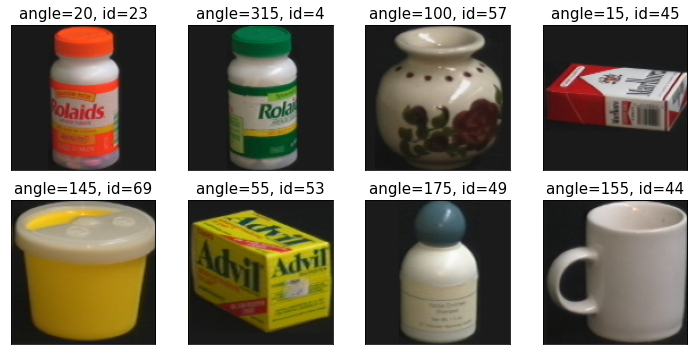

In [44]:
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    img = features['image'][i, :, :, :]
    ax = fig.add_subplot(2, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(f"angle={features['angle'][i]}, id={labels[i].numpy()}", size=15)
    
plt.tight_layout()
plt.show()

For the second approach, it turns out that `tfds` has a wrapper function called `load` that performs all the three steps. We will use this to fetch the MNIST dataset.

In [26]:
MNIST, MNIST_info = tfds.load('mnist', with_info=True, shuffle_files=False)
print(MNIST_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/particle1331/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [27]:
train_dataset, test_dataset = MNIST['train'], MNIST['test']
train_dataset = train_dataset.map(lambda d: (d['image'], d['label']))
test_dataset = test_dataset.map(lambda d: (d['image'], d['label']))

print(type(train_dataset))
print(train_dataset)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<MapDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


2022-03-12 03:42:21.244895: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


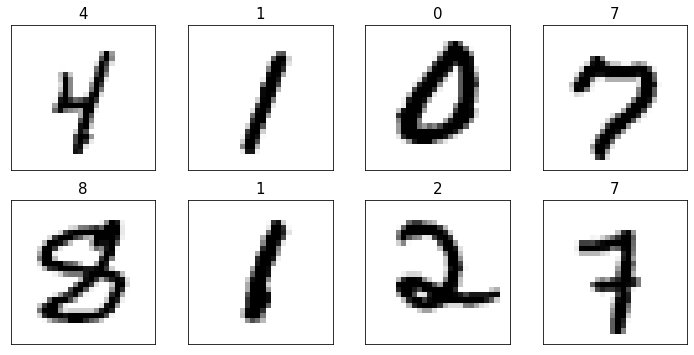

In [29]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataset.batch(8)))
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    img = images[i, :, :, :]
    ax = fig.add_subplot(2, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f"{labels[i].numpy()}", size=15)
    
plt.tight_layout()
plt.show()

## Using TF datasets to train Keras models

```{margin}
⚠️ This section requires knowledge of the **Keras API** discussed in the notebook [Mechanics of TensorFlow](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/02-tensorflow-mechanics.html).
```

So far we have learned about the basic utility components of 
TensorFlow for manipulating tensors and organizing data into formats that we 
can iterate over during training. In this section, we look at how to feed data into TensorFlow models.

### Writing a custom training loop

**Dataset.** In this section, we train a simple linear regression model derived from `tf.keras.Model` by implementing SGD from scratch. The loop iterates over a `tf.data.Dataset` object which acts as a data loader. We use a 2-layer MLP to learn the artificial dataset composed of 10 points below.

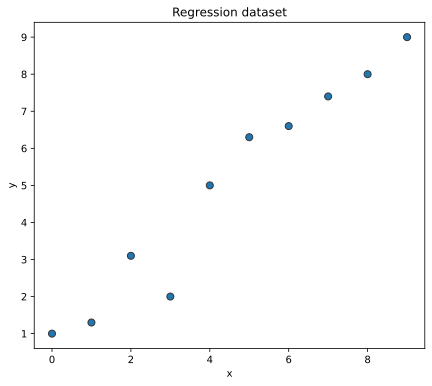

In [45]:
import numpy as np

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

plt.figure(figsize=(7, 6), dpi=80)
plt.scatter(X_train, y_train, edgecolor="#333", s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression dataset')
plt.show()

In [46]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices((
    tf.cast(X_train_norm, tf.float32), 
    tf.cast(y_train, tf.float32)
))

<br>

**Model.** We implement a univariate linear regression model by subclassing the Keras `Model` class.

In [47]:
class RegressionModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')
    
    def call(self, x):
        return self.w * x + self.b

<br>

**Training loop.** The `train` function implements a single step of SGD optimization where gradients of the MSE loss function obtained automatically are used to update the weight `w` and bias `b`. Note that using `count=None` on `repeat` will create a batched version of the dataset that repeats infinitely many times. But since we implement no early stopping mechanism, we set `count=200` to train the model for 200 epochs. 

In [48]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        loss = loss_fn(model(inputs), outputs)
    
    dw, db = tape.gradient(loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

Alternatively, we can exploit the `apply_gradients` method of built-in Keras optimizers:

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
optimizer.apply_gradients(zip([dw, db], [model.w, model.b]))
```

Finally, we can implement the train loop by iterating over the batch loader and applying the train step at each iteration:

In [49]:
# Hyperparameters
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 1

# Instantiate model
model = RegressionModel()

# Create batch loader
ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(1)
ds_train = ds_train.repeat(count=NUM_EPOCHS)

ws, bs = [], []
steps_per_epoch = int(np.ceil(len(y_train) / BATCH_SIZE))
for i, batch in enumerate(ds_train):
    ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_value = loss_fn(model(bx), by)
    train(model, bx, by, learning_rate=LEARNING_RATE)
    
    if i%100==0:
        print(f'Epoch {i//steps_per_epoch:4d} Loss {loss_value:>8.4f}')


2022-03-12 03:58:38.503168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch    0 Loss  39.6900
Epoch   10 Loss  36.8364
Epoch   20 Loss  12.3523
Epoch   30 Loss   0.1548
Epoch   40 Loss   2.7536
Epoch   50 Loss   7.6528
Epoch   60 Loss   5.1741
Epoch   70 Loss   3.5155
Epoch   80 Loss   1.9456
Epoch   90 Loss   0.1534
Epoch  100 Loss   0.0212
Epoch  110 Loss   0.0349
Epoch  120 Loss   0.0486
Epoch  130 Loss   0.2200
Epoch  140 Loss   0.3625
Epoch  150 Loss   0.0197
Epoch  160 Loss   0.4670
Epoch  170 Loss   0.4230
Epoch  180 Loss   0.1517
Epoch  190 Loss   0.3615


<br>

**History.** Here we plot the learned model and the history of its parameters. As training progresses, the weight and bias converge to an optimal value.

Final Parameters: w=2.6580, b=4.8795


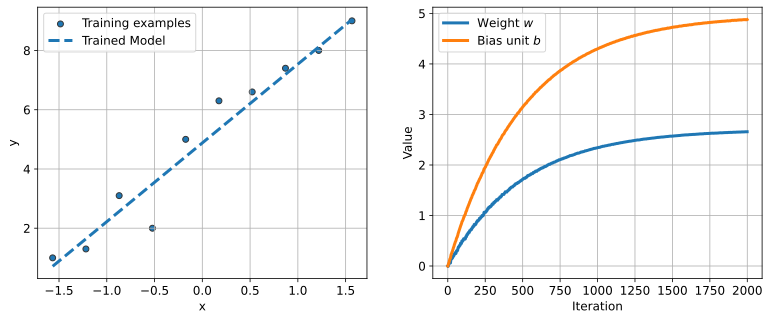

In [50]:
print(f'Final Parameters: w={model.w.numpy():.4f}, b={model.b.numpy():.4f}')

# Generate test set; here test = inference
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

# Get predictions on test set
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))

# Plot learned model
fig = plt.figure(figsize=(13, 5), dpi=600)
ax = fig.add_subplot(1, 2, 1)
plt.scatter(X_train_norm, y_train, c="#1F77B4", edgecolor="#333")
plt.plot(X_test_norm, y_pred, linestyle="--", color='#1F77B4', lw=3)
plt.legend(['Training examples', 'Trained Model'], fontsize=12)
ax.set_xlabel('x', size=12)
ax.set_ylabel('y', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid()

# Plot parameter history
ax = fig.add_subplot(1, 2, 2)
plt.plot(ws, lw=3)
plt.plot(bs, lw=3)
plt.legend([r'Weight $w$', r'Bias unit $b$'], fontsize=12)
ax.set_xlabel('Iteration', size=12)
ax.set_ylabel('Value', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid()

plt.show()

### Fitting on a TensorFlow dataset

In this section, we look at how to obtain a dataset from `tensorflow_datasets` and use it to train a Keras model. In particular we will use the Iris Dataset which consists of 150 observations of the petal and sepal lengths, and petal and sepal widths of 3 different types of irises.


<!-- ```{figure} ../../img/iris.jpeg
---
name: iris
---
From left to right: [Iris setosa](https://commons.wikimedia.org/w/index.php?curid=170298), [Iris versicolor](https://commons.wikimedia.org/w/index.php?curid=248095), and [Iris virginica](https://www.flickr.com/photos/33397993@N05/3352169862).
``` -->

In [51]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info.splits) 

{'train': <SplitInfo num_examples=150, num_shards=1>}


In [52]:
type(iris['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

<br>

**Dataset split.** This only has a train set, so we have to manually split for validation. We can do this with the `.take()` and `.skip()` methods. But this can lead to some unexpected behavior after calling `.shuffle` which converts the dataset to a `ShuffleDataset` which would shuffle the after the initial application of take when creating the train dataset. A workaround is to set `reshuffle_each_iteration` to `False`. 

In [53]:
tf.random.set_seed(1)

# Shuffle data
dataset_orig = iris['train']
N = len(dataset_orig)
dataset_shuffled = dataset_orig.shuffle(N, reshuffle_each_iteration=False)

# Split into train and test sets; transform
train_dataset = dataset_shuffled.take(100)
test_dataset = dataset_shuffled.skip(100)
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

train_dataset = train_dataset.map(lambda d: (d['features'], d['label']))
test_dataset = test_dataset.map(lambda d: (d['features'], d['label']))

Train size: 100
Test size: 50


<br>

**Model.** A two-layer MLP with sigmoid activations should suffice to learn 100 data points:

In [54]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')
])

iris_model.summary() # No need to call .build(), input_shape passed in first dense layer.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


<br>

**Training.** Observe that the Keras `fit` method works with `tf.data` batch loaders:

In [55]:
# Use sparse since targets are 0, 1, 2
iris_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Hyperparameters
NUM_EPOCHS = 50
TRAINING_SIZE = 100
BATCH_SIZE = 8
steps_per_epoch = np.ceil(TRAINING_SIZE / BATCH_SIZE)

# Recall shuffle, batch, repeat pattern to create epochs
train_dataset = train_dataset.shuffle(buffer_size=TRAINING_SIZE)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=1000) # Prepare next elements 
                                                         # while current is preprocessed. 
                                                         # Trades off latency with memory.

# Train model
history = iris_model.fit(train_dataset, epochs=NUM_EPOCHS,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=1)

Epoch 1/50
13/13 [==============================] - 0s 4ms/step - loss: 0.9955 - accuracy: 0.5673
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.8721 - accuracy: 0.7212
Epoch 3/50
 1/13 [=>............................] - ETA: 0s - loss: 0.7783 - accuracy: 0.7500

2022-03-12 03:58:51.329196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 4ms/step - loss: 0.7677 - accuracy: 0.7115
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.7596
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.7212
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.5663 - accuracy: 0.7692
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.5504 - accuracy: 0.7981
Epoch 8/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5086 - accuracy: 0.7500
Epoch 9/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4892 - accuracy: 0.8654
Epoch 10/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.7596
Epoch 11/50
13/13 [==============================] - 0s 4ms/step - loss: 0.4792 - accuracy: 0.7596
Epoch 12/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4444 - accuracy: 0.8462
Epoch 13/50
13/13 [=========

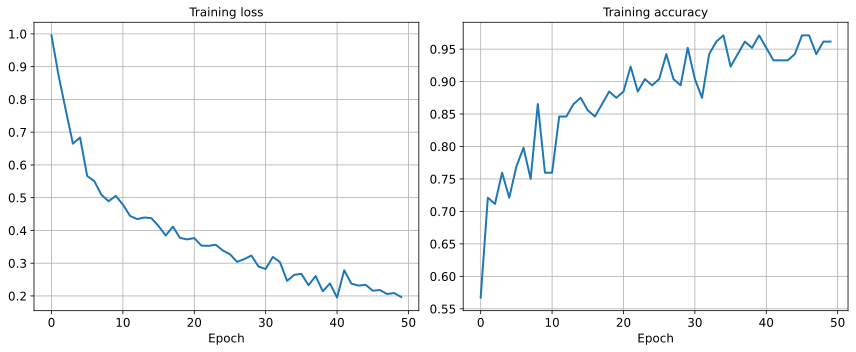

In [56]:
hist = history.history

# Train loss plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax[0].plot(hist['loss'], lw=2)
ax[0].set_title('Training loss', size=12)
ax[0].set_xlabel('Epoch', size=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()

# Accuracy plot
ax[1].plot(hist['accuracy'], lw=2)
ax[1].set_title('Training accuracy', size=12)
ax[1].set_xlabel('Epoch', size=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

plt.tight_layout()

<br>

**Evaluation.** Keras methods `evaluate` (and also `predict`) work nicely with TF dataset objects. We can load the test data into the evaluator as follows:

In [57]:
results = iris_model.evaluate(test_dataset.batch(1), verbose=0) # 50 batches of size 1
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.2095   Test Acc.: 0.9600


2022-03-12 03:58:54.354105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
